In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])


2024-06-26 05:16:30.168288: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 05:16:30.171842: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 05:16:30.213428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 05:16:30.213461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 05:16:30.214625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))

# Seleccionar las columnas necesarias para la serie temporal
columns_to_keep = ['date', 'species', 'Cluster_Label', 'landed_w_kg', 'value_mxn',
                   '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', '5.0782242_m',
                   '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
data = data[columns_to_keep]

# Agrupar por 'species' y 'Cluster_Label', y ordenar cada grupo por 'date'
grouped_data = data.groupby(['species', 'Cluster_Label'])
valid_series = {key: group for key, group in grouped_data if group['date'].nunique() >= 57}

# Extraer las series que cumplen el criterio
filtered_data = pd.concat(valid_series.values())

In [3]:
filtered_data= filtered_data[filtered_data['species']!='OTRAS']

In [4]:
filtered_data['species'].unique()

array(['ALMEJA', 'BANDERA', 'BAQUETA', 'BERRUGATA', 'CABRILLA', 'CALAMAR',
       'CARACOL', 'CAZON', 'CORVINA', 'GUACHINANGO', 'JAIBA', 'JUREL',
       'LENGUADO', 'LISA', 'LOBINA', 'MERO', 'MOJARRA', 'OSTION',
       'PAMPANO', 'PARGO', 'PIERNA', 'PULPO', 'RAYA Y SIMILARES',
       'ROBALO', 'RONCO', 'SARDINA', 'SIERRA', 'TIBURON'], dtype=object)

In [5]:
species_list = ['ALMEJA', 'BANDERA', 'BAQUETA', 'BERRUGATA', 'CABRILLA', 'CALAMAR',
                'CARACOL', 'CAZON', 'CORVINA', 'GUACHINANGO', 'JAIBA', 'JUREL',
                'LENGUADO', 'LISA', 'LOBINA', 'MERO', 'MOJARRA', 'OSTION',
                'PAMPANO', 'PARGO', 'PIERNA', 'PULPO', 'RAYA Y SIMILARES',
                'ROBALO', 'RONCO', 'SARDINA', 'SIERRA', 'TIBURON']

In [6]:
from sklearn.preprocessing import MinMaxScaler


# Función para preparar los datos
def prepare_data(group, look_back=6):
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X, y = [], []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
        y.append(group_scaled[i + look_back, 0])  # La primera columna es 'landed_w_kg'
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, y,scaler


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os


# Función para crear y entrenar un modelo LSTM
def create_and_train_lstm_model(data, species_name, epochs=100, batch_size=12):
    X, y, scaler = prepare_data(data)
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(25, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(12, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Guardar el modelo
    model_directory = 'modelos'  # Asegúrate de que este directorio existe o crea uno
    os.makedirs(model_directory, exist_ok=True)
    model_path = os.path.join(model_directory, f'{species_name}_model.h5')
    model.save(model_path)
    print(f'Modelo guardado en {model_path}')

    # Guardar el scaler
    scaler_path = os.path.join(model_directory, f'{species_name}_scaler.pkl')
    joblib.dump(scaler, scaler_path)

    return model


In [8]:
models = {}
for species in species_list:
    print(f'Entrenamiento de {species}')
    species_data = data[data['species'] == species]  # Filtrar datos por especie
    models[species] = create_and_train_lstm_model(species_data, species)

Entrenamiento de ALMEJA
Epoch 1/50
14977/14977 [==============================] - 51s 3ms/step - loss: 4.3849e-04 - val_loss: 5.4535e-04
Epoch 2/50
14977/14977 [==============================] - 46s 3ms/step - loss: 4.0398e-04 - val_loss: 4.7469e-04
Epoch 3/50
14977/14977 [==============================] - 46s 3ms/step - loss: 3.7389e-04 - val_loss: 4.7698e-04
Epoch 4/50
14977/14977 [==============================] - 47s 3ms/step - loss: 3.6706e-04 - val_loss: 4.5773e-04
Epoch 5/50
14977/14977 [==============================] - 46s 3ms/step - loss: 3.6187e-04 - val_loss: 4.6403e-04
Epoch 6/50
14977/14977 [==============================] - 47s 3ms/step - loss: 3.5659e-04 - val_loss: 4.7533e-04
Epoch 7/50
14977/14977 [==============================] - 47s 3ms/step - loss: 3.5032e-04 - val_loss: 4.6615e-04
Epoch 8/50
14977/14977 [==============================] - 46s 3ms/step - loss: 3.5412e-04 - val_loss: 4.6669e-04
Epoch 9/50
14977/14977 [==============================] - 46s 3ms/step -

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
16232/16232 [==============================] - 53s 3ms/step - loss: 9.4952e-04 - val_loss: 7.4530e-04
Epoch 2/50
16232/16232 [==============================] - 50s 3ms/step - loss: 7.7455e-04 - val_loss: 6.1817e-04
Epoch 3/50
16232/16232 [==============================] - 50s 3ms/step - loss: 7.4115e-04 - val_loss: 6.3413e-04
Epoch 4/50
16232/16232 [==============================] - 49s 3ms/step - loss: 7.3163e-04 - val_loss: 6.4993e-04
Epoch 5/50
16232/16232 [==============================] - 49s 3ms/step - loss: 7.2228e-04 - val_loss: 6.6349e-04
Epoch 6/50
16232/16232 [==============================] - 49s 3ms/step - loss: 7.2812e-04 - val_loss: 6.0294e-04
Epoch 7/50
16232/16232 [==============================] - 49s 3ms/step - loss: 7.2581e-04 - val_loss: 5.9339e-04
Epoch 8/50
16232/16232 [==============================] - 48s 3ms/step - loss: 7.1750e-04 - val_loss: 6.5560e-04
Epoch 9/50
16232/16232 [==============================] - 49s 3ms/step - loss: 7.2228e-04 - val_

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
13887/13887 [==============================] - 45s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/50
13887/13887 [==============================] - 42s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/50
13887/13887 [==============================] - 41s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/50
13887/13887 [==============================] - 41s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/50
13887/13887 [==============================] - 40s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/50
13887/13887 [==============================] - 40s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/50
13887/13887 [==============================] - 40s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/50
13887/13887 [==============================] - 40s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/50
13887/13887 [==============================] - 40s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
13887/13887 [==============================

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
18552/18552 [==============================] - 59s 3ms/step - loss: 0.0027 - val_loss: 9.0937e-04
Epoch 2/50
18552/18552 [==============================] - 56s 3ms/step - loss: 0.0022 - val_loss: 8.8929e-04
Epoch 3/50
18552/18552 [==============================] - 56s 3ms/step - loss: 0.0022 - val_loss: 8.2976e-04
Epoch 4/50
18552/18552 [==============================] - 57s 3ms/step - loss: 0.0020 - val_loss: 7.6908e-04
Epoch 5/50
18552/18552 [==============================] - 56s 3ms/step - loss: 0.0020 - val_loss: 8.4602e-04
Epoch 6/50
18552/18552 [==============================] - 56s 3ms/step - loss: 0.0020 - val_loss: 7.6878e-04
Epoch 7/50
18552/18552 [==============================] - 55s 3ms/step - loss: 0.0020 - val_loss: 7.6068e-04
Epoch 8/50
18552/18552 [==============================] - 55s 3ms/step - loss: 0.0019 - val_loss: 8.4341e-04
Epoch 9/50
18552/18552 [==============================] - 56s 3ms/step - loss: 0.0021 - val_loss: 8.5640e-04
Epoch 10/50
18552/1

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
9352/9352 [==============================] - 31s 3ms/step - loss: 1.0895e-04 - val_loss: 2.1182e-07
Epoch 2/50
9352/9352 [==============================] - 28s 3ms/step - loss: 1.0998e-04 - val_loss: 2.0390e-07
Epoch 3/50
9352/9352 [==============================] - 28s 3ms/step - loss: 1.1100e-04 - val_loss: 1.9458e-07
Epoch 4/50
9352/9352 [==============================] - 27s 3ms/step - loss: 1.1075e-04 - val_loss: 1.9896e-07
Epoch 5/50
9352/9352 [==============================] - 29s 3ms/step - loss: 1.1259e-04 - val_loss: 2.5395e-07
Epoch 6/50
9352/9352 [==============================] - 29s 3ms/step - loss: 1.1097e-04 - val_loss: 1.4604e-06
Epoch 7/50
9352/9352 [==============================] - 29s 3ms/step - loss: 1.1039e-04 - val_loss: 2.1761e-07
Epoch 8/50
9352/9352 [==============================] - 28s 3ms/step - loss: 1.1064e-04 - val_loss: 2.7766e-07
Epoch 9/50
9352/9352 [==============================] - 28s 3ms/step - loss: 1.0989e-04 - val_loss: 2.6448e-07
E

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
3220/3220 [==============================] - 13s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 3/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 7/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 8/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/50
3220/3220 [==============================] - 10s 3ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/50
3220/3220 [==============================] - 10s 3ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
9263/9263 [==============================] - 31s 3ms/step - loss: 9.8030e-04 - val_loss: 6.3568e-04
Epoch 2/50
9263/9263 [==============================] - 29s 3ms/step - loss: 8.1855e-04 - val_loss: 5.0613e-04
Epoch 3/50
9263/9263 [==============================] - 29s 3ms/step - loss: 7.0839e-04 - val_loss: 5.3223e-04
Epoch 4/50
9263/9263 [==============================] - 28s 3ms/step - loss: 6.8444e-04 - val_loss: 4.5809e-04
Epoch 5/50
9263/9263 [==============================] - 28s 3ms/step - loss: 6.2656e-04 - val_loss: 4.1310e-04
Epoch 6/50
9263/9263 [==============================] - 28s 3ms/step - loss: 6.0942e-04 - val_loss: 4.4022e-04
Epoch 7/50
9263/9263 [==============================] - 28s 3ms/step - loss: 6.2399e-04 - val_loss: 4.2342e-04
Epoch 8/50
9263/9263 [==============================] - 28s 3ms/step - loss: 6.0734e-04 - val_loss: 4.5945e-04
Epoch 9/50
9263/9263 [==============================] - 28s 3ms/step - loss: 6.0046e-04 - val_loss: 4.5087e-04
E

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
7881/7881 [==============================] - 27s 3ms/step - loss: 0.0013 - val_loss: 5.9930e-04
Epoch 2/50
7881/7881 [==============================] - 25s 3ms/step - loss: 0.0012 - val_loss: 6.0413e-04
Epoch 3/50
7881/7881 [==============================] - 25s 3ms/step - loss: 0.0011 - val_loss: 5.4629e-04
Epoch 4/50
7881/7881 [==============================] - 25s 3ms/step - loss: 0.0010 - val_loss: 6.1618e-04
Epoch 5/50
7881/7881 [==============================] - 25s 3ms/step - loss: 0.0010 - val_loss: 6.8437e-04
Epoch 6/50
7881/7881 [==============================] - 25s 3ms/step - loss: 0.0010 - val_loss: 5.1528e-04
Epoch 7/50
7881/7881 [==============================] - 25s 3ms/step - loss: 9.9032e-04 - val_loss: 5.6652e-04
Epoch 8/50
7881/7881 [==============================] - 24s 3ms/step - loss: 9.8359e-04 - val_loss: 5.3676e-04
Epoch 9/50
7881/7881 [==============================] - 24s 3ms/step - loss: 9.7789e-04 - val_loss: 5.4133e-04
Epoch 10/50
7881/7881 [==

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36875/36875 [==============================] - 117s 3ms/step - loss: 2.1066e-04 - val_loss: 1.4301e-04
Epoch 2/50
36875/36875 [==============================] - 113s 3ms/step - loss: 1.8156e-04 - val_loss: 1.4260e-04
Epoch 3/50
36875/36875 [==============================] - 112s 3ms/step - loss: 1.6736e-04 - val_loss: 1.4198e-04
Epoch 4/50
36875/36875 [==============================] - 110s 3ms/step - loss: 1.6168e-04 - val_loss: 1.4304e-04
Epoch 5/50
36875/36875 [==============================] - 109s 3ms/step - loss: 1.5918e-04 - val_loss: 1.4482e-04
Epoch 6/50
36875/36875 [==============================] - 109s 3ms/step - loss: 1.5898e-04 - val_loss: 1.6785e-04
Epoch 7/50
36875/36875 [==============================] - 111s 3ms/step - loss: 1.5604e-04 - val_loss: 1.4712e-04
Epoch 8/50
36875/36875 [==============================] - 111s 3ms/step - loss: 1.5506e-04 - val_loss: 1.4305e-04
Epoch 9/50
36875/36875 [==============================] - 107s 3ms/step - loss: 1.5554e-

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
18947/18947 [==============================] - 59s 3ms/step - loss: 4.0044e-04 - val_loss: 5.0573e-04
Epoch 2/50
18947/18947 [==============================] - 56s 3ms/step - loss: 3.4520e-04 - val_loss: 4.3740e-04
Epoch 3/50
18947/18947 [==============================] - 56s 3ms/step - loss: 3.2247e-04 - val_loss: 4.4335e-04
Epoch 4/50
18947/18947 [==============================] - 57s 3ms/step - loss: 3.1538e-04 - val_loss: 4.6454e-04
Epoch 5/50
18947/18947 [==============================] - 56s 3ms/step - loss: 3.1209e-04 - val_loss: 4.5923e-04
Epoch 6/50
18947/18947 [==============================] - 56s 3ms/step - loss: 3.0628e-04 - val_loss: 4.5854e-04
Epoch 7/50
18947/18947 [==============================] - 57s 3ms/step - loss: 3.0560e-04 - val_loss: 5.1200e-04
Epoch 8/50
18947/18947 [==============================] - 58s 3ms/step - loss: 3.0571e-04 - val_loss: 4.3458e-04
Epoch 9/50
18947/18947 [==============================] - 56s 3ms/step - loss: 3.0299e-04 - val_

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
54640/54640 [==============================] - 168s 3ms/step - loss: 2.9418e-05 - val_loss: 1.9994e-05
Epoch 2/50
54640/54640 [==============================] - 166s 3ms/step - loss: 2.8986e-05 - val_loss: 1.0933e-05
Epoch 3/50
54640/54640 [==============================] - 163s 3ms/step - loss: 2.9022e-05 - val_loss: 1.0198e-05
Epoch 4/50
54640/54640 [==============================] - 163s 3ms/step - loss: 2.8920e-05 - val_loss: 1.0592e-05
Epoch 5/50
54640/54640 [==============================] - 164s 3ms/step - loss: 2.9017e-05 - val_loss: 9.9141e-06
Epoch 6/50
54640/54640 [==============================] - 163s 3ms/step - loss: 2.8969e-05 - val_loss: 3.5871e-05
Epoch 7/50
54640/54640 [==============================] - 165s 3ms/step - loss: 2.8596e-05 - val_loss: 9.1610e-06
Epoch 8/50
54640/54640 [==============================] - 165s 3ms/step - loss: 2.7797e-05 - val_loss: 7.8933e-06
Epoch 9/50
54640/54640 [==============================] - 165s 3ms/step - loss: 2.7148e-

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
7887/7887 [==============================] - 27s 3ms/step - loss: 0.0014 - val_loss: 9.4829e-04
Epoch 2/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0013 - val_loss: 9.3818e-04
Epoch 3/50
7887/7887 [==============================] - 23s 3ms/step - loss: 0.0011 - val_loss: 8.5939e-04
Epoch 4/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0011 - val_loss: 8.1463e-04
Epoch 5/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0010 - val_loss: 9.9340e-04
Epoch 6/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0010 - val_loss: 8.6906e-04
Epoch 7/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0010 - val_loss: 7.6655e-04
Epoch 8/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0010 - val_loss: 7.5970e-04
Epoch 9/50
7887/7887 [==============================] - 24s 3ms/step - loss: 0.0010 - val_loss: 8.1091e-04
Epoch 10/50
7887/7887 [==============

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
14580/14580 [==============================] - 48s 3ms/step - loss: 7.0765e-05 - val_loss: 1.6752e-07
Epoch 2/50
14580/14580 [==============================] - 44s 3ms/step - loss: 6.9468e-05 - val_loss: 9.3984e-08
Epoch 3/50
14580/14580 [==============================] - 43s 3ms/step - loss: 7.0389e-05 - val_loss: 8.8965e-08
Epoch 4/50
14580/14580 [==============================] - 44s 3ms/step - loss: 7.0755e-05 - val_loss: 8.8567e-08
Epoch 5/50
14580/14580 [==============================] - 44s 3ms/step - loss: 6.9747e-05 - val_loss: 9.0253e-08
Epoch 6/50
14580/14580 [==============================] - 44s 3ms/step - loss: 7.0044e-05 - val_loss: 9.5060e-08
Epoch 7/50
14580/14580 [==============================] - 44s 3ms/step - loss: 7.1288e-05 - val_loss: 2.0815e-07
Epoch 8/50
14580/14580 [==============================] - 43s 3ms/step - loss: 6.9857e-05 - val_loss: 8.8652e-08
Epoch 9/50
14580/14580 [==============================] - 44s 3ms/step - loss: 7.0372e-05 - val_

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
20068/20068 [==============================] - 63s 3ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 2/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 9/50
20068/20068 [==============================] - 60s 3ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/50
20068/20068 [==============================

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
1129/1129 [==============================] - 7s 4ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 2/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 3/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 4/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 5/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 6/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 7/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 8/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 9/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 10/50
1129/1129 [==============================] - 3s 3ms/step - loss: 0.004

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
2713/2713 [==============================] - 11s 3ms/step - loss: 5.0122e-04 - val_loss: 4.1792e-05
Epoch 2/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9853e-04 - val_loss: 4.2301e-05
Epoch 3/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9607e-04 - val_loss: 4.3053e-05
Epoch 4/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9355e-04 - val_loss: 4.2241e-05
Epoch 5/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9444e-04 - val_loss: 4.1984e-05
Epoch 6/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9315e-04 - val_loss: 4.1668e-05
Epoch 7/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9396e-04 - val_loss: 4.1878e-05
Epoch 8/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9386e-04 - val_loss: 4.8134e-05
Epoch 9/50
2713/2713 [==============================] - 8s 3ms/step - loss: 4.9402e-04 - val_loss: 5.7215e-05
Epoch 10/

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36209/36209 [==============================] - 113s 3ms/step - loss: 4.4621e-04 - val_loss: 2.2981e-04
Epoch 2/50
36209/36209 [==============================] - 110s 3ms/step - loss: 3.4320e-04 - val_loss: 1.5497e-04
Epoch 3/50
36209/36209 [==============================] - 109s 3ms/step - loss: 3.0582e-04 - val_loss: 1.4309e-04
Epoch 4/50
36209/36209 [==============================] - 109s 3ms/step - loss: 2.9494e-04 - val_loss: 1.4785e-04
Epoch 5/50
36209/36209 [==============================] - 108s 3ms/step - loss: 2.9217e-04 - val_loss: 1.9118e-04
Epoch 6/50
36209/36209 [==============================] - 110s 3ms/step - loss: 2.8825e-04 - val_loss: 2.0559e-04
Epoch 7/50
36209/36209 [==============================] - 110s 3ms/step - loss: 2.8901e-04 - val_loss: 2.5414e-04
Epoch 8/50
36209/36209 [==============================] - 109s 3ms/step - loss: 2.8743e-04 - val_loss: 1.6209e-04
Epoch 9/50
36209/36209 [==============================] - 109s 3ms/step - loss: 2.8100e-

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
3100/3100 [==============================] - 13s 3ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 2/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.00

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
4021/4021 [==============================] - 15s 3ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 2/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 3/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 4/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 5/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 6/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 8/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 9/50
4021/4021 [==============================] - 12s 3ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/50
4021/4021 [==============================] - 12s 3ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
41356/41356 [==============================] - 128s 3ms/step - loss: 3.4397e-04 - val_loss: 2.2346e-04
Epoch 2/50
41356/41356 [==============================] - 125s 3ms/step - loss: 3.4407e-04 - val_loss: 2.0286e-04
Epoch 3/50
41356/41356 [==============================] - 125s 3ms/step - loss: 3.4289e-04 - val_loss: 2.0586e-04
Epoch 4/50
41356/41356 [==============================] - 125s 3ms/step - loss: 3.2977e-04 - val_loss: 1.6744e-04
Epoch 5/50
41356/41356 [==============================] - 124s 3ms/step - loss: 2.9048e-04 - val_loss: 1.5774e-04
Epoch 6/50
41356/41356 [==============================] - 125s 3ms/step - loss: 2.7467e-04 - val_loss: 1.6141e-04
Epoch 7/50
41356/41356 [==============================] - 124s 3ms/step - loss: 2.6489e-04 - val_loss: 1.5223e-04
Epoch 8/50
41356/41356 [==============================] - 122s 3ms/step - loss: 2.6176e-04 - val_loss: 1.5369e-04
Epoch 9/50
41356/41356 [==============================] - 123s 3ms/step - loss: 2.5836e-

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
3308/3308 [==============================] - 13s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 2/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 4/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 6/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 9/50
3308/3308 [==============================] - 10s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/50
3308/3308 [==============================] - 10s 3ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
4268/4268 [==============================] - 16s 3ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 2/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 3/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 4/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 7/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/50
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 10/50
4268/4268 [==============================] - 13s 3ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
9751/9751 [==============================] - 33s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 2/50
9751/9751 [==============================] - 29s 3ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 3/50
9751/9751 [==============================] - 30s 3ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/50
9751/9751 [==============================] - 29s 3ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 5/50
9751/9751 [==============================] - 29s 3ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/50
9751/9751 [==============================] - 30s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/50
9751/9751 [==============================] - 29s 3ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/50
9751/9751 [==============================] - 29s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/50
9751/9751 [==============================] - 29s 3ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/50
9751/9751 [==============================] - 29s 3ms/step - l

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
18384/18384 [==============================] - 58s 3ms/step - loss: 0.0011 - val_loss: 6.0310e-04
Epoch 2/50
18384/18384 [==============================] - 55s 3ms/step - loss: 9.3790e-04 - val_loss: 5.2252e-04
Epoch 3/50
18384/18384 [==============================] - 55s 3ms/step - loss: 8.7887e-04 - val_loss: 5.0724e-04
Epoch 4/50
18384/18384 [==============================] - 56s 3ms/step - loss: 8.6861e-04 - val_loss: 4.9517e-04
Epoch 5/50
18384/18384 [==============================] - 56s 3ms/step - loss: 8.2371e-04 - val_loss: 5.1397e-04
Epoch 6/50
18384/18384 [==============================] - 56s 3ms/step - loss: 8.1138e-04 - val_loss: 4.9064e-04
Epoch 7/50
18384/18384 [==============================] - 56s 3ms/step - loss: 8.1452e-04 - val_loss: 4.7239e-04
Epoch 8/50
18384/18384 [==============================] - 56s 3ms/step - loss: 8.1467e-04 - val_loss: 4.9991e-04
Epoch 9/50
18384/18384 [==============================] - 55s 3ms/step - loss: 8.2007e-04 - val_loss

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
2596/2596 [==============================] - 11s 3ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 2/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 5/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/50
2596/2596 [==============================] - 8s 3ms/step - loss: 0.00

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
424/424 [==============================] - 5s 5ms/step - loss: 0.0075 - val_loss: 0.0162
Epoch 2/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0157
Epoch 3/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0155
Epoch 4/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0160
Epoch 5/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0160
Epoch 6/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0156
Epoch 7/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0156
Epoch 8/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0159
Epoch 9/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0157
Epoch 10/50
424/424 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0157

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
27616/27616 [==============================] - 86s 3ms/step - loss: 0.0011 - val_loss: 8.4408e-04
Epoch 2/50
27616/27616 [==============================] - 83s 3ms/step - loss: 8.6705e-04 - val_loss: 8.0313e-04
Epoch 3/50
27616/27616 [==============================] - 83s 3ms/step - loss: 8.2509e-04 - val_loss: 7.9442e-04
Epoch 4/50
27616/27616 [==============================] - 83s 3ms/step - loss: 8.1241e-04 - val_loss: 7.2746e-04
Epoch 5/50
27616/27616 [==============================] - 84s 3ms/step - loss: 7.9211e-04 - val_loss: 7.8434e-04
Epoch 6/50
27616/27616 [==============================] - 84s 3ms/step - loss: 7.8737e-04 - val_loss: 9.4490e-04
Epoch 7/50
27616/27616 [==============================] - 83s 3ms/step - loss: 7.7646e-04 - val_loss: 7.2879e-04
Epoch 8/50
27616/27616 [==============================] - 83s 3ms/step - loss: 7.7097e-04 - val_loss: 7.6924e-04
Epoch 9/50
27616/27616 [==============================] - 84s 3ms/step - loss: 7.6213e-04 - val_loss

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
20326/20326 [==============================] - 64s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/50
20326/20326 [==============================] - 61s 3ms/step - loss: 9.4574e-04 - val_loss: 5.2345e-04
Epoch 3/50
20326/20326 [==============================] - 61s 3ms/step - loss: 8.9761e-04 - val_loss: 6.0140e-04
Epoch 4/50
20326/20326 [==============================] - 61s 3ms/step - loss: 8.5505e-04 - val_loss: 5.4127e-04
Epoch 5/50
20326/20326 [==============================] - 60s 3ms/step - loss: 8.5199e-04 - val_loss: 0.0011
Epoch 6/50
20326/20326 [==============================] - 61s 3ms/step - loss: 8.2578e-04 - val_loss: 6.4990e-04
Epoch 7/50
20326/20326 [==============================] - 60s 3ms/step - loss: 8.4163e-04 - val_loss: 4.9243e-04
Epoch 8/50
20326/20326 [==============================] - 61s 3ms/step - loss: 8.4575e-04 - val_loss: 6.4671e-04
Epoch 9/50
20326/20326 [==============================] - 60s 3ms/step - loss: 8.2838e-04 - val_loss: 5.1926

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from keras.models import load_model
# Función que usa el modelo guardado para hacer una predicción basada en el nombre de la especie
def moe_predict(species_name, X):
    model_path = f'modelos/{species_name}_best_model.h5'
    model = load_model(model_path)  # Cargar el modelo específico de la especie
    prediction = model.predict(X)
    return prediction

import matplotlib.pyplot as plt

#Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

data = data[(data['Cluster_Label'] == 1) & (data['date'] >= '2023-01-01')]
data = data[data['']]

# Lista de especies en el cluster 1
species_list = data['species'].unique()

# Crear subplots para cada especie
fig, axes = plt.subplots(len(species_list), 1, figsize=(12, 5 * len(species_list)), sharex=True)
if len(species_list) == 1:
    axes = [axes]

# Escalar las características como se hizo en el entrenamiento
features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
            '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']

look_back = 3


# Iterar sobre cada especie
for ax, species in zip(axes, species_list):
    species_data = filtered_data[filtered_data['species'] == species]
    
    # Comprobar si hay datos suficientes para la especie
    if species_data.shape[0] < look_back:
        print(f"Not enough data for species {species}")
        continue

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(species_data[features])
    
    # Preparar los datos de prueba
    X_test, y_real = [], []
    for i in range(len(data_scaled) - look_back):
        X_test.append(data_scaled[i:(i + look_back)])
        y_real.append(data_scaled[i + look_back, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], look_back, len(features)))
    
    # Realizar predicciones
    y_pred = moe_predict(species, X_test)
    
    # Escalar los valores de vuelta a la escala original
    y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], len(features) - 1))], axis=1))[:, 0]
    y_real_rescaled = scaler.inverse_transform(np.concatenate([np.array(y_real).reshape(-1, 1), np.zeros((len(y_real), len(features) - 1))], axis=1))[:, 0]
    
    # Graficar los resultados
    ax.plot(species_data['date'][look_back:], y_real_rescaled,marker='o', label='Real')
    ax.plot(species_data['date'][look_back:], y_pred_rescaled,marker='+', label='Predicción')
    ax.set_title(f'{species}')
    ax.set_ylabel('Peso Desembarcado (kg)')
    ax.legend()

plt.xlabel('Fecha')
plt.show()

2024-06-28 02:57:26.488102: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 02:57:26.491132: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-28 02:57:26.540848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 02:57:26.540889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 02:57:26.543123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

NameError: name 'pd' is not defined

533/533 [==============================] - 2s 2ms/step
Not enough data for species CAMARON
781/781 [==============================] - 4s 2ms/step
Not enough data for species OTRAS
304/304 [==============================] - 1s 2ms/step
Not enough data for species ATUN
165/165 [==============================] - 1s 2ms/step
Not enough data for species ALGAS
Not enough data for species BONITO
11/11 [==============================] - 1s 3ms/step
Not enough data for species LEBRANCHA
Not enough data for species LANGOSTA
Not enough data for species RUBIA Y VILLAJAIBA
Not enough data for species ESMEDREGAL
Not enough data for species BARRILETE


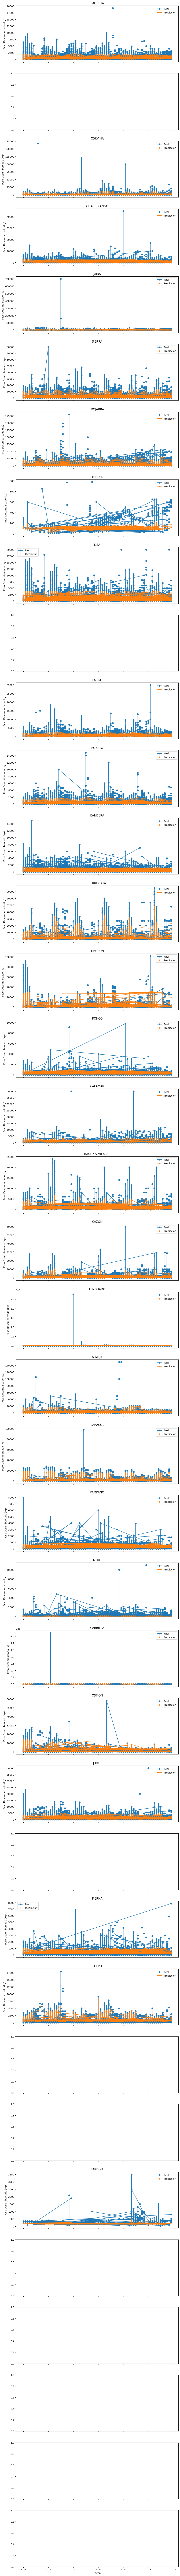